# Gurobi Tutorial
1. Linear Programs
    1. Maximum Flow Problem
    2. Minimum Cut Problem
2. Mixed Integer Programs
3. Advanced Techniques for Speeding Up Gurobi

## Linear Programs
- Linear programs are problems that feature linear functions of variables in an objective function and constraints.
- Essentially the goal is to solve a system of linear equations and increase (or decrease) an objective as much as possible.



### Max Flow Problem
**Transportation Application**: Traffic flow analysis on a network
### Givens
- $V$: Set of nodes. We have one source node $s$ and target node $t$ to send flow from and to (respectively).
- $E$: Set of edges, with associated costs, $c_{ij}$, and flow capacities, $u_{ij}$.
    - We set $c_{ij} = 0, ~\forall~ (i,j) \in E, (i,j)\neq (t,s)$.
    - In this problem, we add an additional arc $(t, s)$ to $E$ with cost, $c_{ts} = 1$.
### Decision Variables
- $x_{ij}$: Amount of flow on edge $(i, j)\in E$.
### Objective
- Want to maximize the flow sent from $s$ to $t$.

\begin{eqnarray}
    & \max & \sum_{(i,j)\in E} c_{ij}x_{ij} =  x_{ts} &&\\
    &&  \text{subject to:} \\
    &&  \sum_{j: (j, i) \in E} x_{ji} - \sum_{j:(i,j)\in E} x_{ij} = 0, ~\forall~ i \in V &&\mbox{\textemdash flow balance at each node}\\
    &&  x_{ij} \leq u_{ij}, ~\forall~ (i, j) \in E &&\mbox{\textemdash capacity of each link} ~j\\
    &&  x_{ij} \geq 0, ~\forall~ (i, j)\in E &&\mbox{\textemdash demand allocation decision}
\end{eqnarray}

In [2]:
# import all necessary packages
import time
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
from itertools import product
import networkx as nx

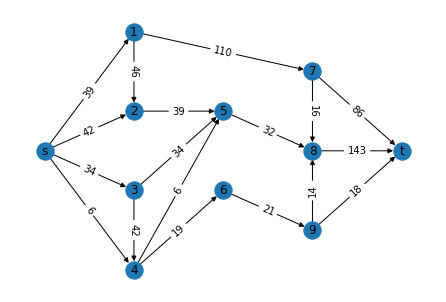

In [3]:
# generate example graph
G = nx.DiGraph()
seed = 12345
np.random.seed(seed)
s = 's'
t = 't'
G.add_nodes_from([(s, dict(layer=1)), (t, dict(layer=5)), (1, dict(layer=2)), (2, dict(layer=2)), (3, dict(layer=2)),
                  (4, dict(layer=2)), (5, dict(layer=3)), (6, dict(layer=3)), (7, dict(layer=4)), (8, dict(layer=4)),
                  (9, dict(layer=4))])
G.add_edges_from([(t, s, dict(c=1, u=9999)), (s, 1, dict(c=0, u=np.random.randint(5, 50))),
                  (s, 2, dict(c=0, u=np.random.randint(5, 50))), (s, 3, dict(c=0, u=np.random.randint(5, 50))),
                  (s, 4, dict(c=0, u=np.random.randint(5, 50))), (1, 2, dict(c=0, u=np.random.randint(5, 50))),
                  (1, 2, dict(c=0, u=np.random.randint(5, 50))), (3, 4, dict(c=0, u=np.random.randint(5, 50))),
                  (2, 5, dict(c=0, u=np.random.randint(5, 50))), (3, 5, dict(c=0, u=np.random.randint(5, 50))),
                  (4, 5, dict(c=0, u=np.random.randint(5, 25))), (4, 6, dict(c=0, u=np.random.randint(5, 50))),
                  (1, 7, dict(c=0, u=np.random.randint(5, 500))), (5, 8, dict(c=0, u=np.random.randint(5, 50))),
                  (6, 9, dict(c=0, u=np.random.randint(5, 50))), (9, 8, dict(c=0, u=np.random.randint(5, 50))),
                  (7, 8, dict(c=0, u=np.random.randint(5, 50))), (9, t, dict(c=0, u=np.random.randint(5, 50))),
                  (8, t, dict(c=0, u=np.random.randint(5, 150))), (7, t, dict(c=0, u=np.random.randint(5, 100)))])
ax = nx.draw(G, pos=nx.multipartite_layout(G, subset_key='layer'),
             with_labels=True, edgelist=list(set(list(G.edges)).difference({(t,s)})))
edge_labels = {e: G.edges[e]['u'] for e in G.edges if e != (t, s)}
ax = nx.draw_networkx_edge_labels(G, pos=nx.multipartite_layout(G, subset_key='layer'), edge_labels=edge_labels)

In [4]:
# Max Flow
nodes = list(G.nodes)
edges, costs, caps = gp.multidict({e: [G.edges[e]['c'], G.edges[e]['u']] for e in G.edges})
# alternative
# edges = list(G.edges)
# cost_dict= {e: G.edges[e]['c'] for e in edges}
# cap_dict = {e: G.edges[e]['u'] for e in edges}

t0 = time.time()
# initialize model
model = gp.Model('Maximum Flow Problem')
# model.setParam('OutputFlag', 0)     # suppress output from Gurobi
# add decision variables
# edge flow dec. var.
x = model.addVars(edges, lb=0, ub=caps, obj=costs, name='x')

# add objective function
model.setObjective(gp.quicksum(x[i, j] * costs[i, j] for i, j in edges), gp.GRB.MAXIMIZE)
# model.setObjective(x[t, s], gp.GRB.MAXIMIZE)

# add constraints
# flow balance constraints (using star notation)
# Gurobi star notation selects all elements used to specify the variable that have an index that matches a condition
# for example, in the constraint below, we sum over all incoming edges into a fixed node i, the <select> function with '*' does exactly that
model.addConstrs((gp.quicksum(x.select('*', i)) - gp.quicksum(x.select(i, '*')) == 0 for i in nodes), name='flow_balance')
# alternative form
# model.addConstrs((gp.quicksum(x[j, i] for j in nodes if (j, i) in edges) -
#                   gp.quicksum(x[i, j] for j in nodes if (i, j) in edges) == 0 for i in nodes), name='flow_balance')
print('WRITE MODEL:: {v0}s'.format(v0=round(time.time() - t0, 4)))

t0 = time.time()
# optimize model
model.optimize()
print('SOLVE MODEL:: {v0}s'.format(v0=round(time.time() - t0, 4)))

# extract solution
x_val = model.getAttr('x', x).items()  # get demand allocation  values
x_val = {i: v for i, v in x_val}
obj_val = model.ObjVal      # get objective value


Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-15
WRITE MODEL:: 0.0247s
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 11 rows, 19 columns and 38 nonzeros
Model fingerprint: 0x7123e1d9
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [6e+00, 1e+04]
  RHS range        [0e+00, 0e+00]
Presolve removed 5 rows and 5 columns
Presolve time: 0.00s
Presolved: 6 rows, 14 columns, 28 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1904000e+02   9.304000e+01   0.000000e+00      0s
       3    9.0000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.000000000e+01
SOLVE MODEL:: 0.0135s


Max Flow: 90.0


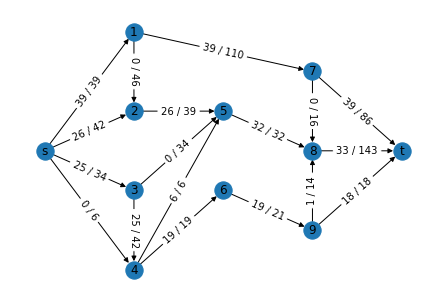

In [5]:
# plotting
nx.draw(G, pos=nx.multipartite_layout(G, subset_key='layer'),
             with_labels=True, edgelist=list(set(list(G.edges)).difference({(t,s)})))
edge_labels = {e: '{v0} / {v1}'.format(v0=int(x_val[e]), v1=G.edges[e]['u']) for e in G.edges if e != (t, s)}
nx.draw_networkx_edge_labels(G, pos=nx.multipartite_layout(G, subset_key='layer'), edge_labels=edge_labels)
print('Max Flow: {v0}'.format(v0=x_val[t,s]))

## Min Cut Problem (Dual)
Duality is a concept in optimization that states that every **primal** Linear Program has a corresponding **dual** problem that has:
- as many variables as there are constraints in the **primal** problem
- as many constraints as there are variables in the **primal** problem
- the same optimal objective function values

Solving the dual of an LP is equivalent to solving the original LP
Why is it useful?
- Certain problems have nicer structures, allowing for a better solution method using the Dual Simplex Method.
- The dual of a problem may be easier to interpret.
- Dual variable values give information on problem and optimal solutions (shadow prices).
- Advanced solution techniques (e.g., Benders' Decomposition) rely on dual problem solution.
- Column generation for the **primal** problem is equivalent to constraint generation (cutting planes) for its **dual** problem.

\begin{eqnarray}
    & \min & \sum_{(i,j)\in E} u_{ij} q_{ij} &&\\
    &&  \text{subject to:} \\
    &&  p_j - p_i - q_{ij} \leq 0, ~\forall~ (i, j)\in E, (i,j)\neq(t,s) &&\\
    &&  p_s - p_t - q_{ts} \leq -1 && \\
    &&  p_i \in \mathbb{R}, ~\forall~ i\in V &&\\
    &&  q_{ij} \geq 0, ~\forall~ (i, j)\in E &&
\end{eqnarray}

**Transportation Application**: Identifying bottlenecks on transportation networks, identifying maximum capacity

In [6]:
# Min Cut
nodes = list(G.nodes)
edges, costs, caps = gp.multidict({e: [G.edges[e]['c'], G.edges[e]['u']] for e in G.edges})
# alternative
# edges = list(G.edges)
# cost_dict= {e: G.edges[e]['c'] for e in edges}
# cap_dict = {e: G.edges[e]['u'] for e in edges}

t0 = time.time()
# initialize model
model = gp.Model('Min Cut Problem')
model.setParam('OutputFlag', 0)     # suppress output from Gurobi
# add decision variables
# node-dual cut dec. var.
p = model.addVars(nodes, name='p')
# edge-dual cut dec. var.
q = model.addVars(edges, lb=0, obj=caps, name='q')

# add objective function: optional
# model.setObjective(gp.quicksum(q[i, j] * caps[i, j] for i, j in edges if (i, j) != (t, s)), gp.GRB.MINIMIZE)
# model.setObjective(gp.quicksum(q[i, j] * caps[i, j] for i, j in edges), gp.GRB.MINIMIZE)

# add constraints
# cut balance constraints
model.addConstrs((p[j] - p[i] - q[i, j] <= -costs[i, j] for (i, j) in edges), name='cut_balance')
print('WRITE MODEL:: {v0}s'.format(v0=round(time.time() - t0, 4)))

t0 = time.time()
# optimize model
model.optimize()
print('SOLVE MODEL:: {v0}s'.format(v0=round(time.time() - t0, 4)))


# extract solution
p_val = model.getAttr('x', p).items()  # node-cut values
q_val = model.getAttr('x', q).items()  # edge-cut values
p_val = {i: v for i, v in p_val}
q_val = {i: v for i, v in q_val}
obj_val = model.ObjVal      # get objective value

WRITE MODEL:: 0.0041s
SOLVE MODEL:: 0.0014s


Min Cut: 90.0


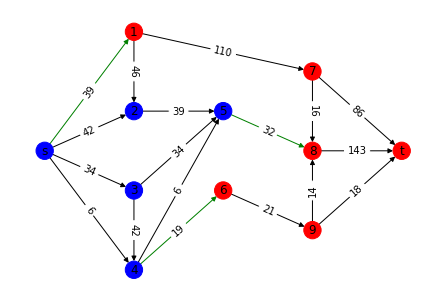

In [7]:
# plotting
nx.draw(G, pos=nx.multipartite_layout(G, subset_key='layer'),
             with_labels=True, edgelist=[e for e in edges if e != (t,s)],
             node_color=['r' if p_val[n] else 'b' for n in nodes],
             edge_color=['g' if q_val[e] == 1 else 'k' for e in edges if e != (t, s)])
edge_labels = {e: '{v1}'.format(v1=G.edges[e]['u']) for e in G.edges if e != (t, s)}
nx.draw_networkx_edge_labels(G, pos=nx.multipartite_layout(G, subset_key='layer'), edge_labels=edge_labels)
print('Min Cut: {v0}'.format(v0=sum(caps[i, j] * q_val[i,j] for (i, j) in edges)))

## Mixed Integer Programs (MIP)
- Mixed integer programs have a mix of **integer** and **continuous** variables.
- This mixed problem complicates solution for many problems.
- Many of the most challenging problems we want to solve are MIPs or pure IPs.
- Many solution methods rely on iteratively improving the problem bounds:
    - Branch and bound
    - Branch and cut
    - Cutting planes (constraint generation)
    - Column generation
    - Benders' Decomposition

## Capactitated Facility Location Problem
### Givens
- $I$: Set of customers with given demands, $d_i$, and locations in space.
- $J$: Set of potential facility locations with fixed installation costs, $f_j$, and capacities, $s_j$.
- $c_{ij}$: Travel costs from facility $j$ to customer $i$.
### Decision Variables
- $y_j$: Decision to locate a facility at location $j$ (1 if selected, 0 otherwise).
- $x_{ij}$: Amount of goods shipped from facility $j$ to customer $i$.
### Objective
- Want to minimize sum of facility construction costs and transportation costs needed to serve all customers $I$.

\begin{eqnarray}
    & \min & \sum_{j \in J} f_j y_j + \sum_{i\in I} \sum_{j\in J} c_{ij} x_{ij} &&\\
    &&  \text{subject to:} \\
    &&  \sum_{j\in J} x_{ij} = d_i, ~\forall~ i\in I &&\mbox{\textemdash demand at location} ~i\\
    &&  \sum_{i\in I} x_{ij} \leq s_j y_j, ~\forall~ j\in J &&\mbox{\textemdash capacity of facility} ~j\\
    &&  x_{ij} \geq 0, ~\forall~ i\in I, j\in J &&\mbox{\textemdash demand allocation decision} \\
    &&  y_j \in \{0, 1\}, ~\forall~ j\in J &&\mbox{\textemdash facility location decision}
\end{eqnarray}

### Example Problem
- $n$ customer locations randomly generated from a uniform unit square
- $m$ candidate facility locations randomly selected from set of customer locations
- $d_i$ randomly generated for each customer
- $s_j$ randomly generated for each facility (assume/ensure $\sum_{j\in J}s_j \geq \sum_{i\in I}d_i$)
- $f_j$ randomly generated for each facility
- $c_{ij}$ calculated based on Euclidean distances


In [10]:
# generate data for example
# initialize random seed
seed = 12345
np.random.seed(seed)
# customer locations
n = 100       # number of customers
cust_coords = np.random.rand(n, 2)       # (x, y) coords of customer locations
# customer demands
dem_low = 10
dem_high = 100
cust_demands = np.random.randint(dem_low, dem_high, n)
# candidate facility locations
m_ratio = 0.1   # percentage of customer locations to sample from as candidate facility locations
m = int(m_ratio * n)
fac_coords = np.array([cust_coords[i, :] for i in np.random.choice(n, m, replace=False)])    # (x, y) coords of candidate facility locations
# facility costs
cost_low = 10
cost_high = 50
fac_costs = np.random.randint(cost_low, cost_high, m)
# facility capacities
cap_low = 100
cap_high = 10000
fac_caps = np.random.randint(cap_low, cap_high, m)
# travel distance costs
dists = np.zeros((n, m))
for j in range(m):
    dists[:, j] = np.sqrt((cust_coords[:, 0] - fac_coords[j, 0]) ** 2 + (cust_coords[:, 1] - fac_coords[j, 1]) ** 2)


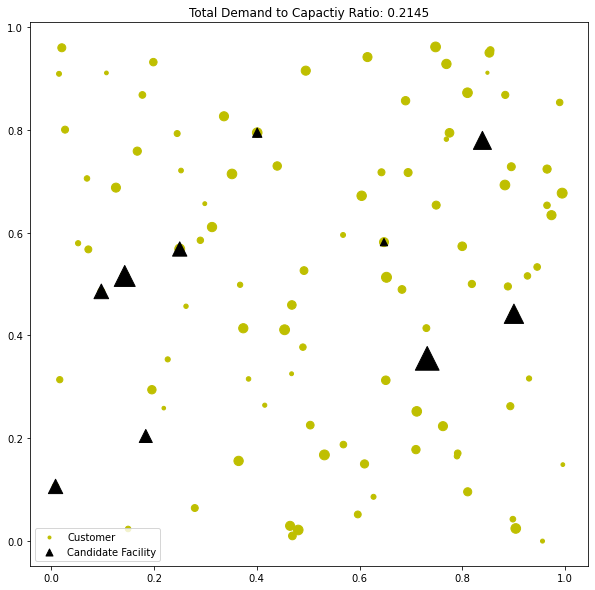

In [13]:
# plotting
_, ax = plt.subplots(figsize=(10, 10))
ax.scatter(cust_coords[:, 0], cust_coords[:, 1], s=cust_demands, c='y', label='Customer')
ax.scatter([x for x, _ in fac_coords], [y for _, y in fac_coords], s=fac_caps/10, c='k', marker='^', label='Candidate Facility')
ax.set_title('Total Demand to Capactiy Ratio: {v0}'.format(v0=round(sum(cust_demands) / sum(fac_caps),4)))
lgnd = ax.legend(loc='lower left', markerscale=0.4)
plt.show()

In [15]:
# Capactitated Facility Location
t0 = time.time()
# initialize model
model = gp.Model('Capacitated Facility Location Problem')
model.setParam('OutputFlag', 0)     # suppress output from Gurobi

# add decision variables
# facility location dec. var.
facs = [j for j in range(m)]
y = model.addVars(facs, vtype=gp.GRB.BINARY, obj=fac_costs, name='y')

# demand allocation dec. var.
custs = [i for i in range(n)]
cust_fac_comb = [c for c in product(custs, facs)]    # combination of customers and candidate facility locations
x = model.addVars(cust_fac_comb, lb=0, obj=[dists[i, j] for i, j in cust_fac_comb], name='x')

# add objective function: optional (implied from <obj> parameter in <model.addVars> function
# model.setObjective(gp.quicksum(y[j] * fac_costs[j] for j in facs) + gp.quicksum(x[i, j] * dists[i, j] for i, j in cust_fac_comb),
#                    gp.GRB.MINIMIZE)

# add constraints
# demand satisfaction constraints
model.addConstrs((gp.quicksum(x[i, j] for j in facs) == cust_demands[i] for i in custs), name='customer_demands')
# alternative forms (star notation, or one-by-one)
# model.addConstrs((gp.quicksum(x.select(i, '*')) == cust_demands[i] for i in custs), name='customer_demands')
# for i in custs:
#     # must add indexer to name if using <name> param for this method
#     model.addConstr(gp.quicksum(x[i, j] for j in facs) == cust_demands[i], name='customer_demands_{v0}')
# facility capacity constraints
model.addConstrs((gp.quicksum(x[i, j] for i in custs) <= fac_caps[j] * y[j] for j in facs), name='facility_capacities')
print('WRITE MODEL:: {v0}s'.format(v0=round(time.time() - t0, 4)))

t0 = time.time()
# optimize model
model.optimize()
print('SOLVE MODEL:: {v0}s'.format(v0=round(time.time() - t0, 4)))

# TODO: if model suspected to be infeasible or unbounded
if model.Status == gp.GRB.INF_OR_UNBD:
    model.setParam(gp.GRB.Param.DualReductions, 0)
    model.optimize()
    if model.Status == gp.GRB.INFEASIBLE:
        print('MODEL INFEASIBLE')
    elif model.Status == gp.GRB.UNBOUNDED:
        print('MODEL UNBOUNDED')


# extract solution
y_val = model.getAttr('x', y).items()  # get facility location values
x_val = model.getAttr('x', x).items()  # get demand allocation  values
obj_val = model.ObjVal      # get objective value


WRITE MODEL:: 0.008s
SOLVE MODEL:: 0.0282s


#### Things to watch out for:
- Naming constraints - must be careful with naming constraints as reusing an active name can replace an existing constraint. It is important to make sure any indices used to name constraints are not used elsewhere.
- Scaling - coefficient values out of scale will cause rounding issues with MIP integer variables.
- Indexing - ensure variables and associated coefficient values can be indexed with the same set of indices.
- Objective sense - ensure the objective sense is correct and activated if not correct.
- Model unbounded or infeasible.

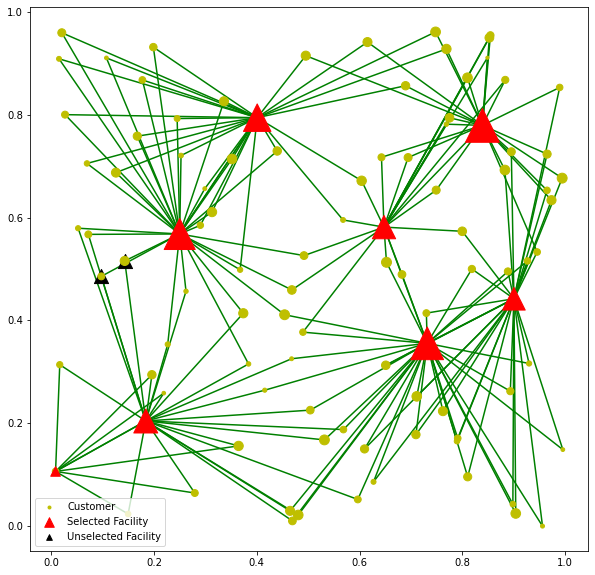

In [24]:
# plotting
y_vs = {i: v for i, v in y_val}
x_vs = {i: v for i, v in x_val}             # convert to dict
fac_sizes = np.array([0 if y_vs[j] == 0 else sum(x_vs[i, j] for i in custs) for j in facs])

_, ax = plt.subplots(figsize=(10, 10))
ax.scatter(cust_coords[:, 0], cust_coords[:, 1], s=cust_demands, c='y', label='Customer')
ax.scatter([x for x, _ in fac_coords], [y for _, y in fac_coords], s=fac_sizes, c='r', marker='^', label='Selected Facility')
ax.scatter([x for j, (x, _) in enumerate(fac_coords) if y_vs[j] == 0],
           [y for j, ( _, y) in enumerate(fac_coords) if y_vs[j] == 0], s=200, c='k', marker='^', label='Unselected Facility', zorder=0)
# customer-facility assignment
for i in custs:
    for j in facs:
        if x_vs[i, j]:
            ax.plot([cust_coords[i, 0], fac_coords[j, 0]], [cust_coords[i, 1], fac_coords[j, 1]], 'g', zorder=-1)
lgnd = ax.legend(loc='lower left', markerscale=0.4)
plt.show()

### Constraint Generation
Gurobi allows you to add constraints to an existing model and reoptimize it.
Let's add constraints that do not allow more than 90% of a customer's demand to come from the same facility.

In [25]:
# adding supply redundancy constraints
model.addConstrs((x[i, j] <= 0.9 * cust_demands[i] for i in custs for j in facs), name='supply_redundancy')
# model.addConstrs((x.select(i, '*') <= 0.9 * cust_demands[i] for i in custs), name='supply_redundancy')
t0 = time.time()
# optimize model
model.optimize()
print('SOLVE MODEL:: {v0}s'.format(v0=round(time.time() - t0, 4)))

# extract solution
y_val = model.getAttr('x', y).items()  # get facility location values
x_val = model.getAttr('x', x).items()  # get demand allocation  values
obj_val = model.ObjVal      # get objective value

SOLVE MODEL:: 0.0254s


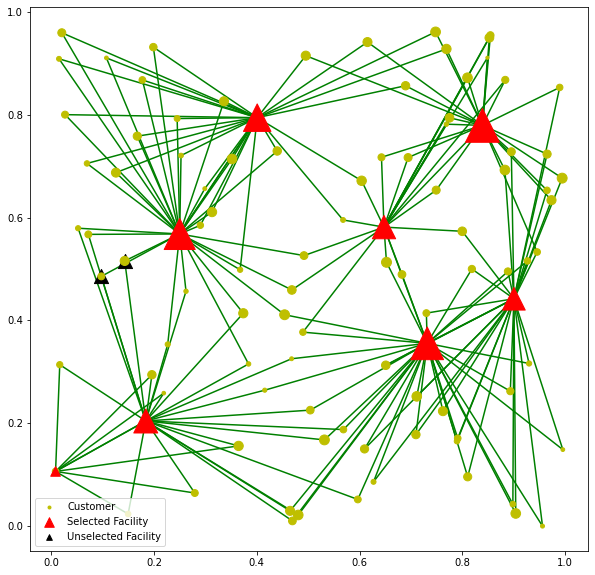

In [26]:
# plotting
y_vs = {i: v for i, v in y_val}
x_vs = {i: v for i, v in x_val}             # convert to dict
fac_sizes = np.array([0 if y_vs[j] == 0 else sum(x_vs[i, j] for i in custs) for j in facs])

_, ax = plt.subplots(figsize=(10, 10))
ax.scatter(cust_coords[:, 0], cust_coords[:, 1], s=cust_demands, c='y', label='Customer')
ax.scatter([x for x, _ in fac_coords], [y for _, y in fac_coords], s=fac_sizes, c='r', marker='^', label='Selected Facility')
ax.scatter([x for j, (x, _) in enumerate(fac_coords) if y_vs[j] == 0],
           [y for j, ( _, y) in enumerate(fac_coords) if y_vs[j] == 0], s=200, c='k', marker='^', label='Unselected Facility', zorder=0)
# customer-facility assignment
for i in custs:
    for j in facs:
        if x_vs[i, j]:
            ax.plot([cust_coords[i, 0], fac_coords[j, 0]], [cust_coords[i, 1], fac_coords[j, 1]], 'g', zorder=-1)
lgnd = ax.legend(loc='lower left', markerscale=0.4)
plt.show()

## Advanced Techniques for Speeding Up Gurobi
Many times, writing the model can take a long time. Gurobi has many options for speeding this part up.
Gurobi has a good interface with matrices and numpy arrays.
Solving the matrix form of the LP or MIP can help with reducing this time.


In [28]:
n = 500
m = 1000
t0 = time.time()
model = gp.Model('Sample Matrix Setup')
y = model.addMVar((n,), vtype=gp.GRB.BINARY)
y_factor = np.random.rand(n, m)
y_b = np.random.rand(m)

C2= model.addConstr(y_factor.transpose() @ y <= y_b)

print('WRITE MODEL MATRIX:: {v0}s'.format(v0=time.time() - t0))

t0 = time.time()
model = gp.Model('Sample Matrix Setup')
y = model.addVars(range(n), vtype=gp.GRB.BINARY)
y_factor = np.random.rand(n, m)
y_b = np.random.rand(m)

for j in range(m):
    model.addConstr(gp.quicksum(y_factor[i, j] * y[i] for i in range(n)) <= y_b[j])

print('WRITE MODEL ONE-BY-ONE:: {v0}s'.format(v0=time.time() - t0))


WRITE MODEL MATRIX:: 0.04409289360046387s
WRITE MODEL ONE-BY-ONE:: 10.192620992660522s


## References
[1] Wentges, P. Accelerating Benders’ Decomposition for the Capacitated Facility Location Problem. Mathematical Methods of Operations Research, Vol. 44, No. 2, 1996, pp. 267–290. https://doi.org/10.1007/BF01194335.
[2] Laporte, G., S. Nickel, and F. Saldanha Da Gama, Eds. Location Science. Springer International Publishing, Cham, 2015.